In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import math
import numpy as np

In [ ]:
img = Image.open("../images/")

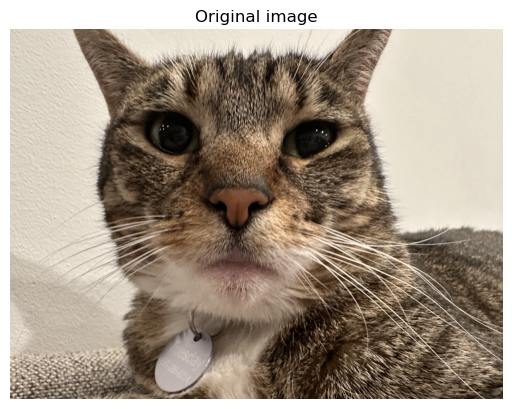

In [12]:
plt.imshow(img)
plt.axis('off')
plt.title("Original image")
plt.show()

### Code for Kuwahara filter below (could prob be optimized)

In [ ]:
window_size = 12

# convert to hsv space
img = img.convert('HSV')

# create new image
result = Image.new('HSV', img.size)

# size of each quadrant of a window
quadrant_size = math.ceil(window_size / 2)

# loop over original image
for y in range(img.height):
    for x in range(img.width):
        # top left position of window
        tl_x = int(np.floor(x - (window_size / 2)))
        tl_y = int(np.floor(y - (window_size / 2)))

        mid_x = int(np.floor(min(img.size[0], tl_x+quadrant_size)))
        mid_y = int(np.floor(min(img.size[1], tl_y+quadrant_size)))
        wind_x = int(np.ceil(min(img.size[0], tl_x+window_size)))
        wind_y = int(np.ceil(min(img.size[1], tl_y+window_size)))

        pixels = img.load()
        img_np = np.array(img)

        quadrant_a = img_np[tl_y:mid_y, tl_x:mid_x]
        quadrant_b = img_np[tl_y:mid_y, mid_x:wind_x]
        quadrant_c = img_np[mid_y:wind_y, tl_x:mid_x]
        quadrant_d = img_np[mid_y:wind_y, mid_x:wind_x]

        values_a = [pix[2] for pix in quadrant_a]
        values_b = [pix[2] for pix in quadrant_b]
        values_c = [pix[2] for pix in quadrant_c]
        values_d = [pix[2] for pix in quadrant_d]

        # get standard deviations
        sigma_a = np.std(values_a)
        sigma_b = np.std(values_b)
        sigma_c = np.std(values_c)
        sigma_d = np.std(values_d)

        quadrants = [quadrant_a, quadrant_b, quadrant_c, quadrant_d]
        minIndex = np.argmin([sigma_a, sigma_b, sigma_c, sigma_d])

        quadrant = quadrants[minIndex]
        
        r = int(np.mean([rgb[0] for rgb in quadrant]))
        g = int(np.mean([rgb[1] for rgb in quadrant]))
        b = int(np.mean([rgb[2] for rgb in quadrant]))

        result.putpixel((x, y), (r, g, b))

KeyboardInterrupt: 

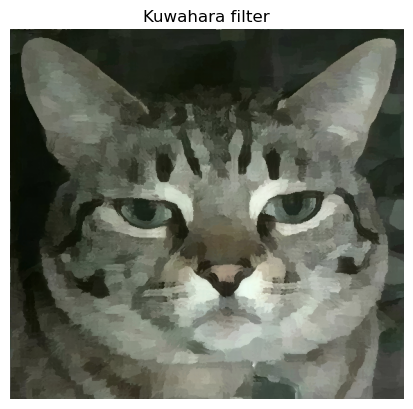

In [9]:
plt.imshow(result)
plt.axis('off')
plt.title("Kuwahara filter")
plt.show()